In [1]:
# Import necessary libraries and check GPU availability
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
else:
    print("GPU is not available, using CPU instead.")

GPU is available and will be used.


In [2]:
# Dataset paths (fold2-selected)
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold2_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Test'

In [3]:
img_size = (224, 224)
batch_size = 16

In [4]:
# Function to create data augmentation pipelines
def augment_class_specific(class_name):
    if class_name in ['Chickenpox', 'Monkeypox']:
        # More aggressive augmentations for Chickenpox and Monkeypox
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=60,
            width_shift_range=0.5,
            height_shift_range=0.5,
            shear_range=0.4,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            fill_mode='nearest',
            preprocessing_function=lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2)
        )
    else:
        # Lighter augmentations for other classes
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.4,
            height_shift_range=0.4,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

# Test data augmentation (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Function to load data with class-specific augmentations
def load_data():
    train_datagen = augment_class_specific("Chickenpox")
    validation_datagen = augment_class_specific("Monkeypox")
    
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

Found 7126 images belonging to 6 classes.
Found 164 images belonging to 6 classes.
Found 82 images belonging to 6 classes.


In [6]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_densenet = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_densenet = dict(enumerate(class_weights_densenet))

In [7]:
# Build the DenseNet model
def build_densenet_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 100 layers of DenseNet
    for layer in base_model.layers[-100:]:
        layer.trainable = True
    
    # Add custom layers for classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_densenet = build_densenet_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_densenet = ModelCheckpoint("best_model_densenet.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_densenet = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_densenet = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights and callbacks
history_densenet = model_densenet.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_densenet,
    callbacks=[checkpoint_densenet, early_stopping_densenet, lr_scheduler_densenet]
)

# Evaluate the model on the test set
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator)
print(f"Test accuracy: {test_acc_densenet}")

# Save the final model
model_densenet.save('final_densenet_model.keras')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729380309.644690     113 service.cc:145] XLA service 0x7a1104003480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729380309.644738     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729380400.166996     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/446 ━━━━━━━━━━━━━━━━━━━━ 1:48 381ms/step - accuracy: 0.2403 - loss: 2.6266

I0000 00:00:1729380557.429372     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_15', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_17', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_18', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_19', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion', 620 bytes spill stores, 600 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_1', 592 bytes spil

446/446 ━━━━━━━━━━━━━━━━━━━━ 437s 641ms/step - accuracy: 0.2883 - loss: 2.3480 - val_accuracy: 0.4939 - val_loss: 1.4210 - learning_rate: 1.0000e-04
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 151s 336ms/step - accuracy: 0.4809 - loss: 1.4137 - val_accuracy: 0.5671 - val_loss: 1.4007 - learning_rate: 1.0000e-04
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 149s 331ms/step - accuracy: 0.5780 - loss: 1.1515 - val_accuracy: 0.6463 - val_loss: 0.8502 - learning_rate: 1.0000e-04
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 150s 331ms/step - accuracy: 0.6168 - loss: 0.9839 - val_accuracy: 0.6646 - val_loss: 1.0832 - learning_rate: 1.0000e-04
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/step - accuracy: 0.6434 - loss: 0.9572 - val_accuracy: 0.6220 - val_loss: 0.9624 - learning_rate: 1.0000e-04
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 150s 332ms/step - accuracy: 0.6958 - loss: 0.7613 - val_accuracy: 0.6829 - val_loss: 0.9314 - learning_rate: 2.0000e-05
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Classification Report for DenseNet Model:
              precision    recall  f1-score   support

  Chickenpox       0.69      0.82      0.75        11
      Cowpox       1.00      1.00      1.00         4
        HFMD       0.73      0.95      0.83        20
     Healthy       0.62      0.91      0.74        11
     Measles       0.75      0.60      0.67         5
   Monkeypox       0.89      0.55      0.68        31

    accuracy                           0.76        82
   macro avg       0.78      0.80      0.78        82
weighted avg       0.79      0.76      0.75        82

Precision: 0.7877147723906387
Recall: 0.7560975609756098
F1 Score: 0.7479661050233691


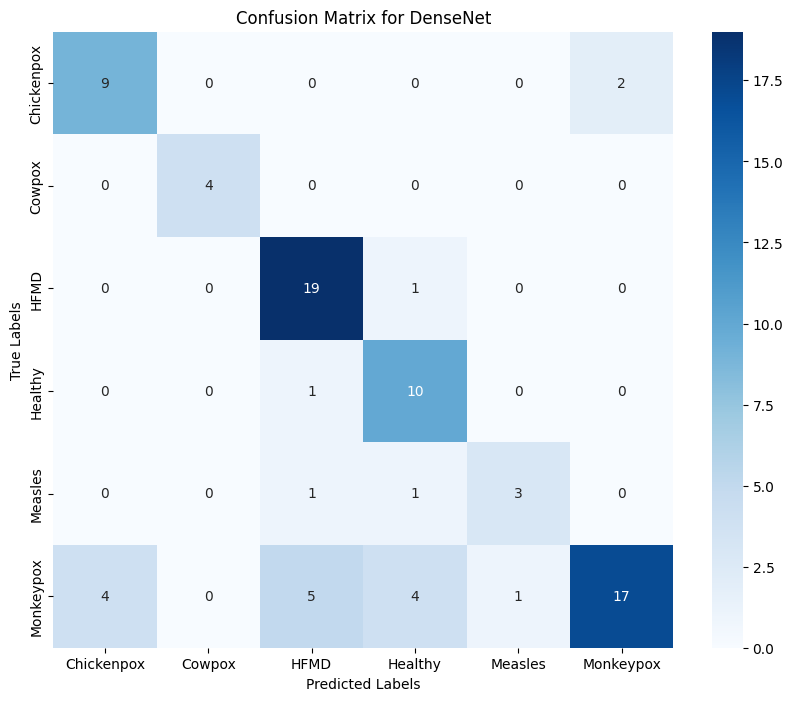

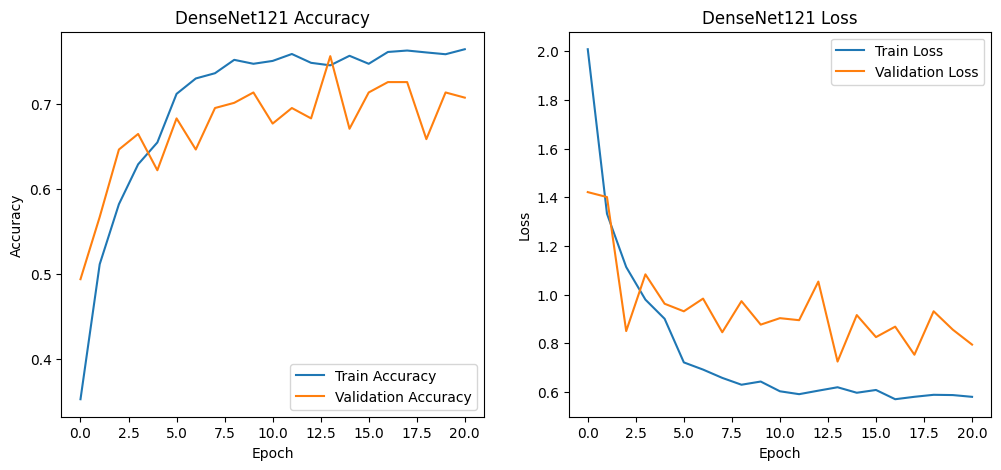

In [8]:
# Predictions on the test set
preds_densenet = model_densenet.predict(test_generator)
y_preds_densenet = np.argmax(preds_densenet, axis=1)
y_true_densenet = test_generator.classes

# Classification report
print("Classification Report for DenseNet Model:")
print(classification_report(y_true_densenet, y_preds_densenet, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_densenet = accuracy_score(y_true_densenet, y_preds_densenet)
precision_densenet = precision_score(y_true_densenet, y_preds_densenet, average='weighted', zero_division=0)
recall_densenet = recall_score(y_true_densenet, y_preds_densenet, average='weighted', zero_division=0)
f1_densenet = f1_score(y_true_densenet, y_preds_densenet, average='weighted', zero_division=0)

print(f"Precision: {precision_densenet}")
print(f"Recall: {recall_densenet}")
print(f"F1 Score: {f1_densenet}")

# Confusion matrix
cm_densenet = confusion_matrix(y_true_densenet, y_preds_densenet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for DenseNet')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_densenet, model_name="DenseNet121")